In [1]:
import os
import numpy as np
import muspy
from tqdm import tqdm
import config
import utils
import tarfile
import shutil
import collections
from matplotlib import pyplot as plt
import json
import tensorflow as tf

config_string = "single_instruments_type"

ROOT_PATH = os.path.abspath(os.path.join(os.getcwd(), os.pardir))
conf = config.Config(config_string, ROOT_PATH)

chosen_datasets = ["lmd_matched"]

2022-11-13 01:45:05.174523: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2022-11-13 01:45:05.314132: E tensorflow/stream_executor/cuda/cuda_blas.cc:2981] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2022-11-13 01:45:05.787710: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer.so.7'; dlerror: libnvinfer.so.7: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /usr/local/cuda-11.6/lib64:/usr/local/cuda-11.6/lib64:/usr/local/cuda-11.6/lib64
2022-11-13 01:45:05.787763: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvin

# Warning, ~ 10 hours required

In [2]:
# lmd = utils.get_dataset("lmd", conf)
# maestro = utils.get_dataset("maestro", conf)
# nes = utils.get_dataset("nes", conf)
# hymn = get_dataset("hymn", conf)
# folk = utils.get_dataset("folk", conf)
lmd_matched = utils.get_dataset("lmd_matched", conf)

In [3]:
# print("folk: {}, maestro: {}, nes: {}, tot: {}".format(
#     len(folk), 
#     len(maestro), 
#     len(nes), 
#     len(folk)+len(maestro)+len(nes)))


---
## Data exploration

In [4]:
dataset = lmd_matched

In [5]:
print(len(dataset))
flag = False
for i in tqdm(range(len(dataset))):

    # check if same instrument is used multiple times
    # if collections.Counter(np.unique(list(track.program for track in dataset[i].tracks)))  \
    #     != collections.Counter(list(track.program for track in dataset[i].tracks)):
    #     print(i)
    
    # check if there are key_signatures
    # if len(k_signs := dataset[i].key_signatures) > 1: 
    #     print(k_signs)
    #     print(i)

    # if len(t_signs := dataset[i].time_signatures) > 1: 
    #     print(t_signs)
    #     print(i)

    # if len(tempo := dataset[i].tempos) > 1: 
    #     print(tempo)
    #     print(i)

    # for track in dataset[i].tracks:
    #     if track.is_drum:
    #         print(i)
    pass

115190


100%|██████████| 115190/115190 [00:00<00:00, 1089757.66it/s]


In [6]:
dataset[0].tracks[0].notes[0]

Note(time=7, pitch=69, duration=64, velocity=100)

In [7]:
def get_stats(dataset):
    stats = {
        "n_tracks" : np.zeros(1000),            # how many instruments are playing in a song (can also be 2 of the same instrument)
        "programs" : np.zeros(1000),             # which type of instrument
        "pitch": np.zeros(500),
        "velocity" : np.zeros(128),             # how loud (0-127)
        "durations": {},          # how many quarters does the note last(?)
        "drum_durations": {},
        "tempos": [],                           # how fast is the song in qpm (quarters per minute) --> can be non integer
        "time_signatures": {},                  # 4/4 or 3/4 etc... store it as a dict
        "key_signatures": {},        # which is the main key
        "len_notes": [],
        "len_drums": []
    }

    for song in tqdm(dataset):

        resolution = song.resolution
        # how many tracks are in the song (tracks = different "instrument voices" but could be 4 pianos)
        stats["n_tracks"][len(song)] += 1 
        

        # how many different instruments and which
        programs = np.unique(list(track.program for track in song.tracks))  
        for program in programs:
            stats["programs"][program] += 1


        # stats on key signatures
        key_signatures = list(set((key_sign.root, key_sign.mode) for key_sign in song.key_signatures)) 

        for key_sign in key_signatures:
            if key_sign in stats["key_signatures"].keys():
                stats["key_signatures"][key_sign] += 1
            else:
                stats["key_signatures"][key_sign] = 1


        # stats on time_signatures --> need to know which exist / are used to create possible tokens
        time_signatures = list(set((time_sign.numerator, time_sign.denominator) for time_sign in song.time_signatures)) 

        for time_sign in time_signatures:
            if time_sign in stats["time_signatures"].keys():
                stats["time_signatures"][time_sign] += 1
            else:
                stats["time_signatures"][time_sign] = 1

        # stats on tempos
        tempos = list(set(tempo.qpm for tempo in song.tempos))

        for tempo in tempos:
            stats["tempos"].append(tempo)

        # notes
        tot_notes = 0
        tot_drums = 0
        for track in song.tracks:

            if len(track) > 0:
                stats["programs"][track.program] += 1

                if track.is_drum:
                    tot_drums += len(track.notes)

                    for note in track.notes:

                        stats["pitch"][note.pitch + 128] += 1
                        stats["velocity"][note.velocity] += 1
                        
                        # duration / resolution = duration in beath lengths
                        if (dur := note.duration / resolution) in stats["drum_durations"].keys():
                            stats["drum_durations"][dur] += 1
                        else:
                            stats["drum_durations"][dur] = 1
                else:
                    tot_notes += len(track.notes)

                    for note in track.notes:
                        stats["pitch"][note.pitch] += 1
                        stats["velocity"][note.velocity] += 1

                        # duration / resolution = duration in beath lengths
                        if (dur := note.duration / resolution) in stats["durations"].keys():
                            stats["durations"][dur] += 1
                        else:
                            stats["durations"][dur] = 1

        stats["len_notes"].append(tot_notes)
        stats["len_drums"].append(tot_drums)
    return stats

In [8]:
stats = get_stats(dataset)            

100%|██████████| 115190/115190 [47:52<00:00, 40.11it/s] 


In [20]:
def plot_scatter_limit(a, lim=-1):
    plt.scatter(range(len(a[:lim])), np.sort(a)[:lim]);


def plot_bar_centered(a, lim=None):
    min_idx = len(a)
    max_idx = 0
    for i, n in enumerate(list(a)):
        if n>0:
            if i < min_idx:
                min_idx = i
            if i > max_idx:
                max_idx = i

    plt.figure(figsize=(26,5))
    if lim != None:
        plt.bar(range(len(a[lim[0]:lim[1]])), a[lim[0]:lim[1]])
        plt.xticks(ticks=range(0,lim[1]-lim[0]), labels=range(lim[0], lim[1]), rotation=90);
        print("The remaining not shown values amount to {:.2f}% of the total".format((sum(a[lim[1]:])+sum(a[:lim[0]]))/sum(a)*100))
    else:
        plt.bar(range(len(a[min_idx:max_idx])), a[min_idx:max_idx])
        plt.xticks(ticks=range(0,max_idx-min_idx), labels=range(min_idx, max_idx), rotation=90);


def plot_scatter_from_dict(d, lim_percentage=0, mapping=None, conf: config.Config = None ):

    if mapping == None:
        mapping = lambda x: x
    tot = np.sum(list(d.values()))
    arr = np.zeros((len(d.keys()), 2))
    for i, key in enumerate(d.keys()):
        arr[i,0] = mapping(key, conf)
        arr[i,1] = d[key]/tot*100

    plt.scatter([x[0] for x in arr if x[1] > lim_percentage], [x[1] for x in arr if x[1] > lim_percentage])
    print("The remaining not shown values amount to {:.2f}% of the total".format(sum([x[1] for x in arr if x[1] <= lim_percentage])/sum(arr[:,1])*100))


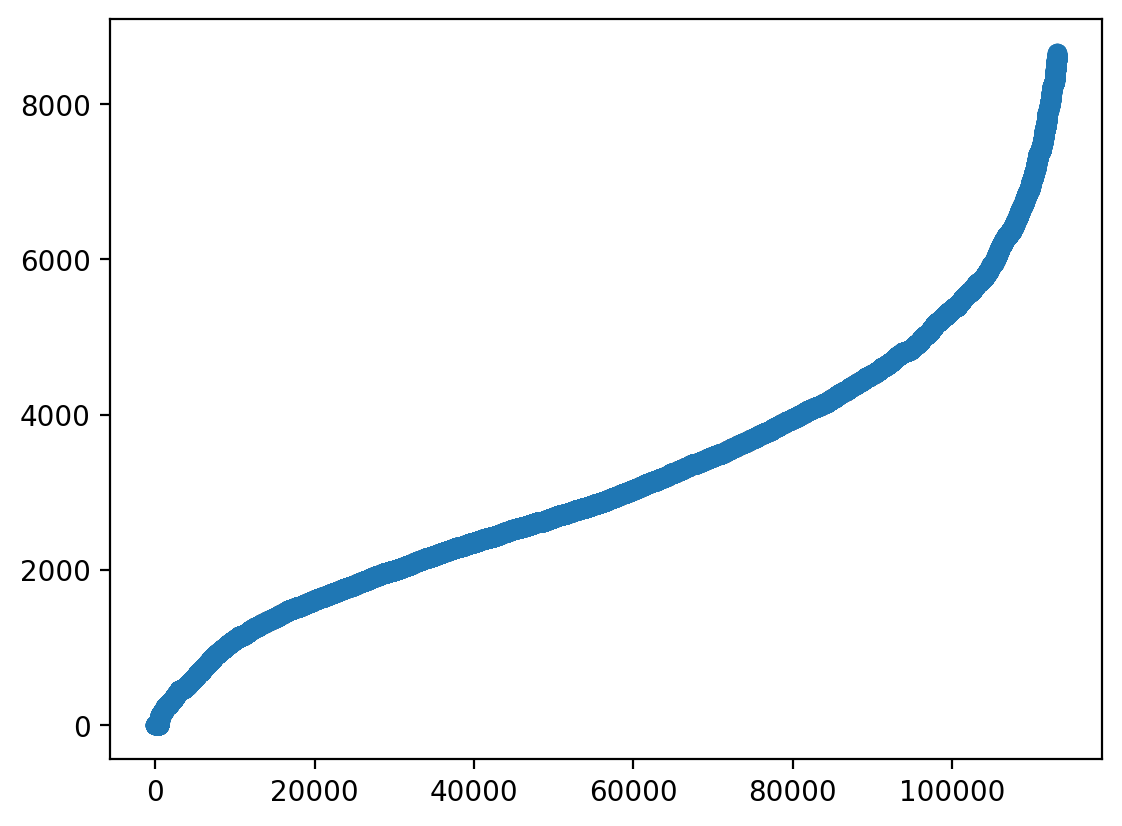

In [10]:
plot_scatter_limit(stats["len_notes"], lim=-2000)

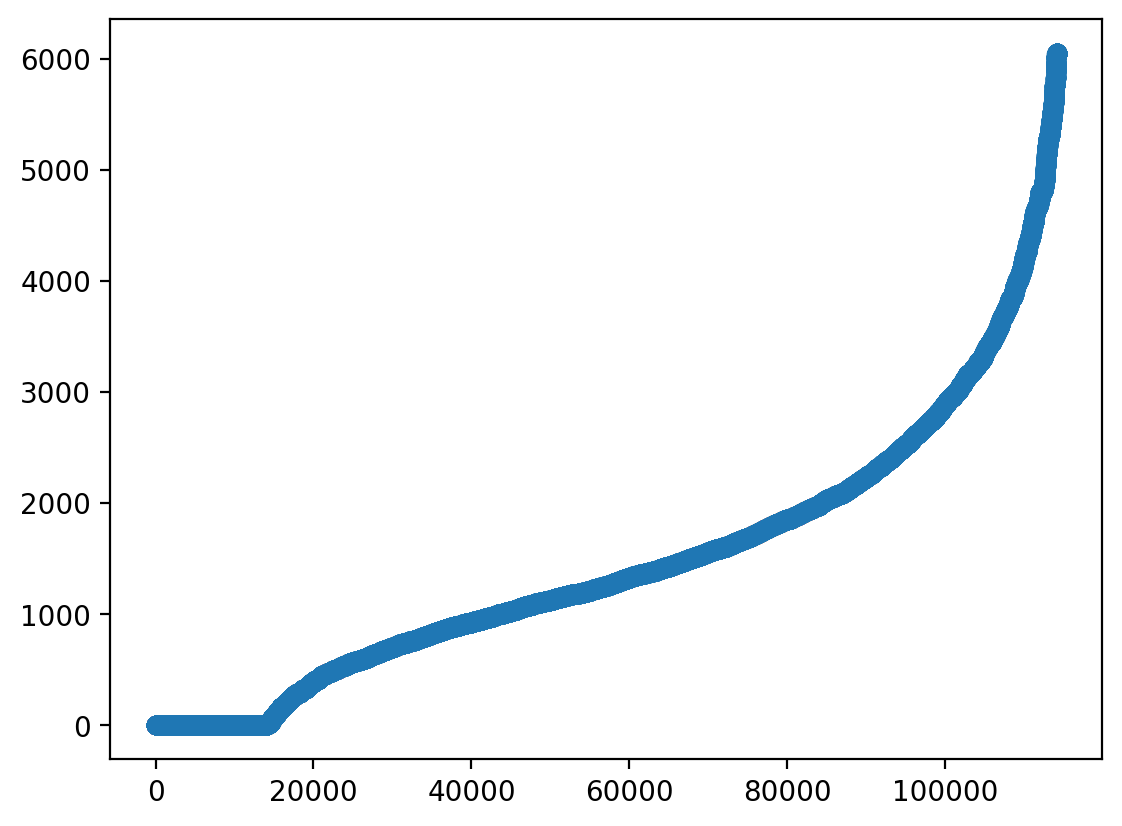

In [11]:
plot_scatter_limit(stats["len_drums"], lim=-1000)

The remaining not shown values amount to 0.14% of the total


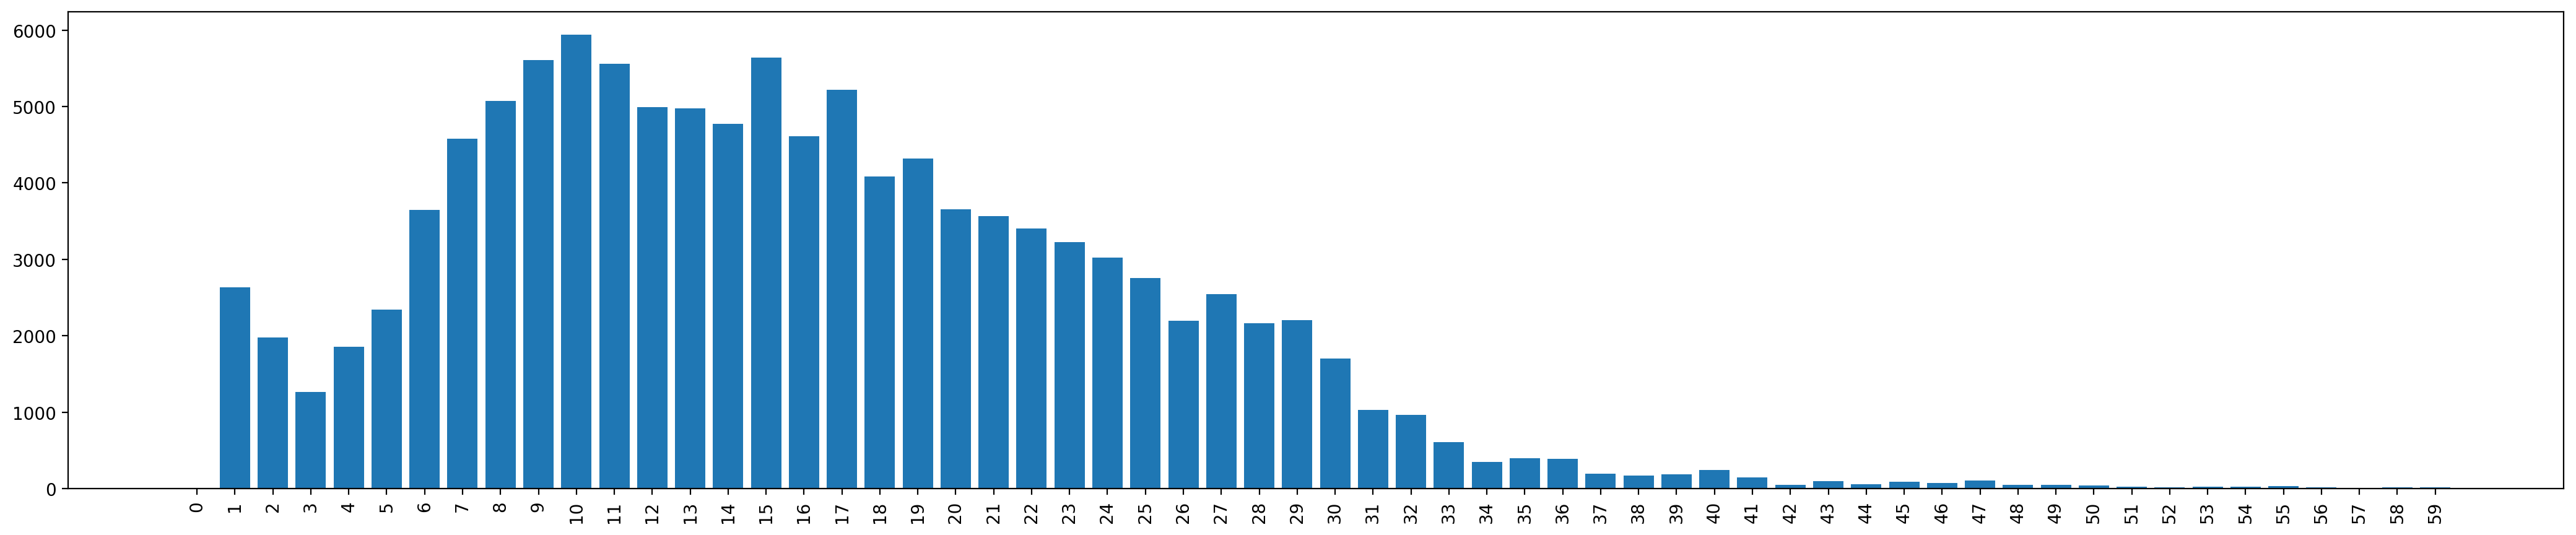

In [12]:
plot_bar_centered(stats["n_tracks"], lim=[0, 60])

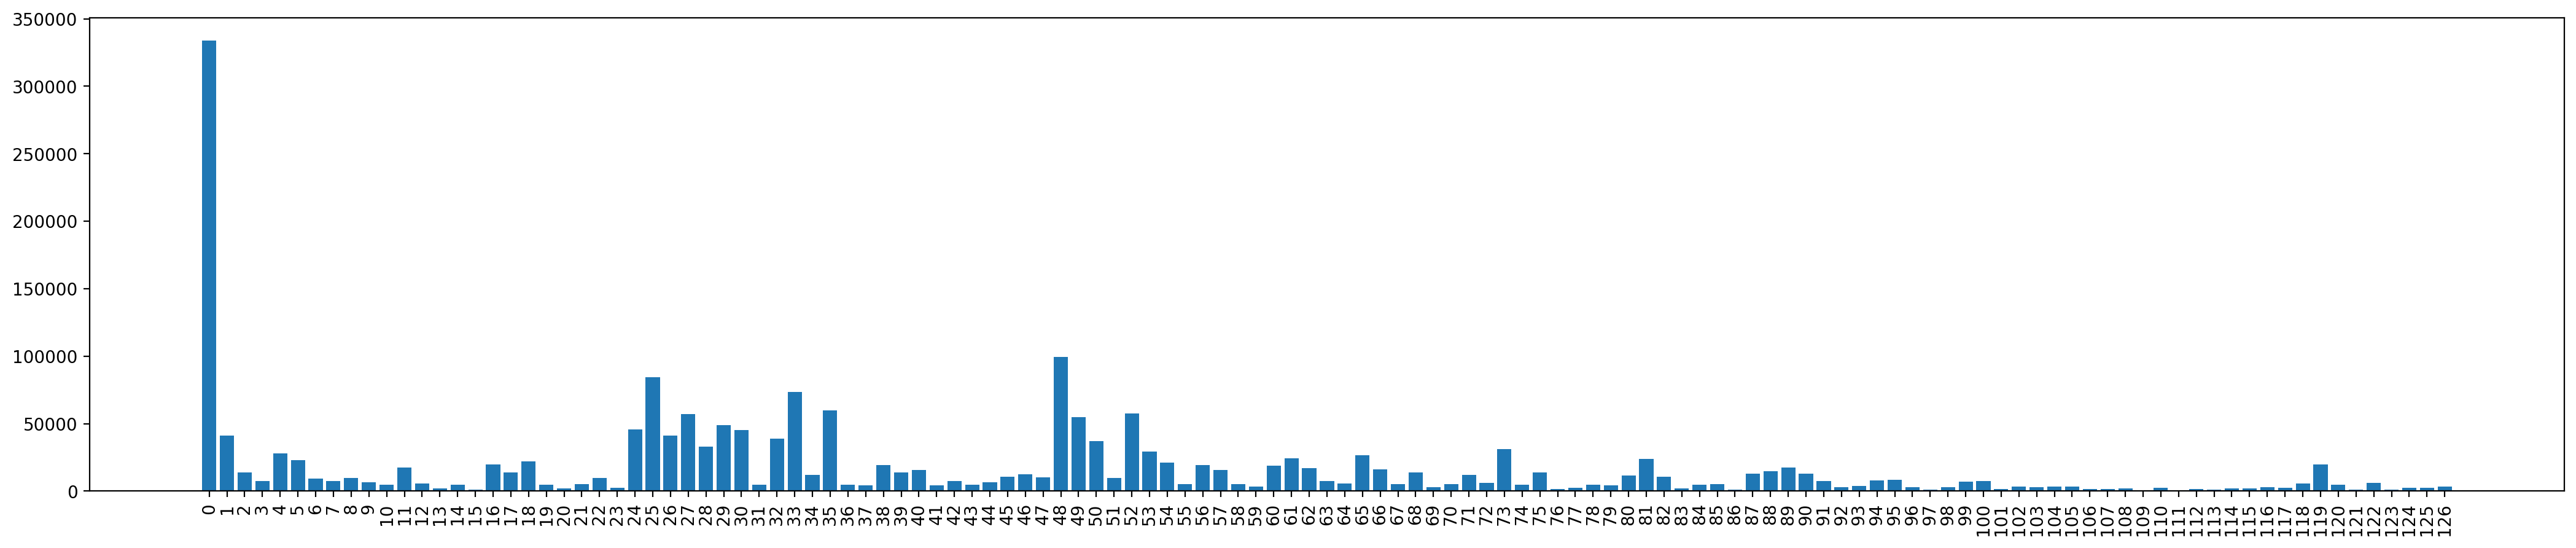

In [13]:
plot_bar_centered(stats["programs"])

The remaining not shown values amount to 0.07% of the total


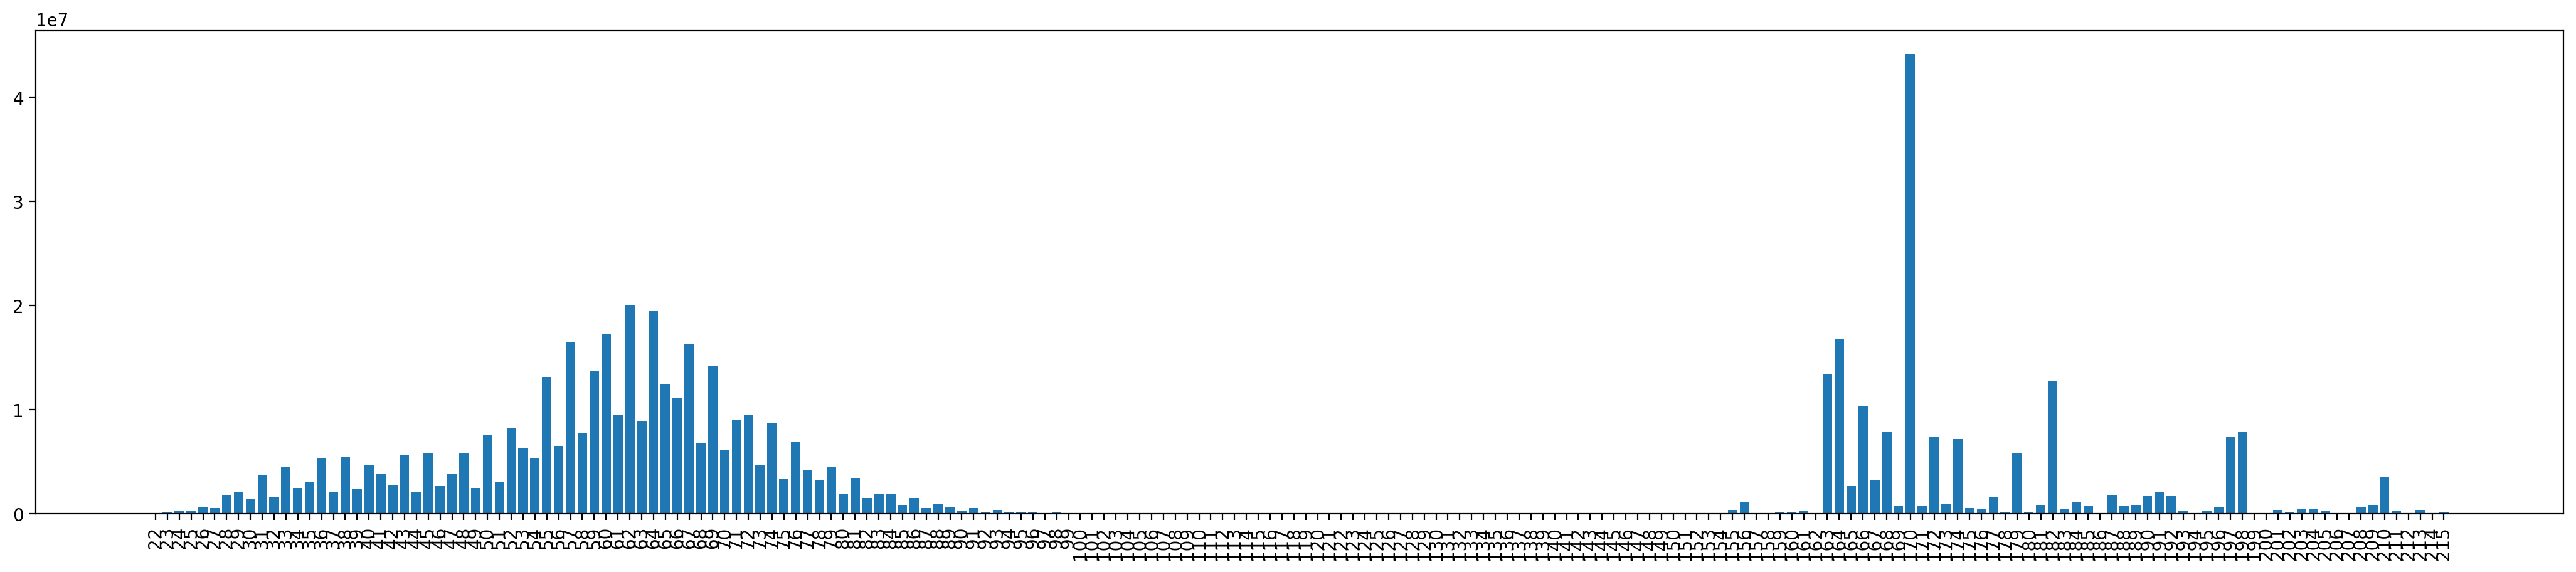

In [14]:
plot_bar_centered(stats["pitch"], lim=[22, 216])

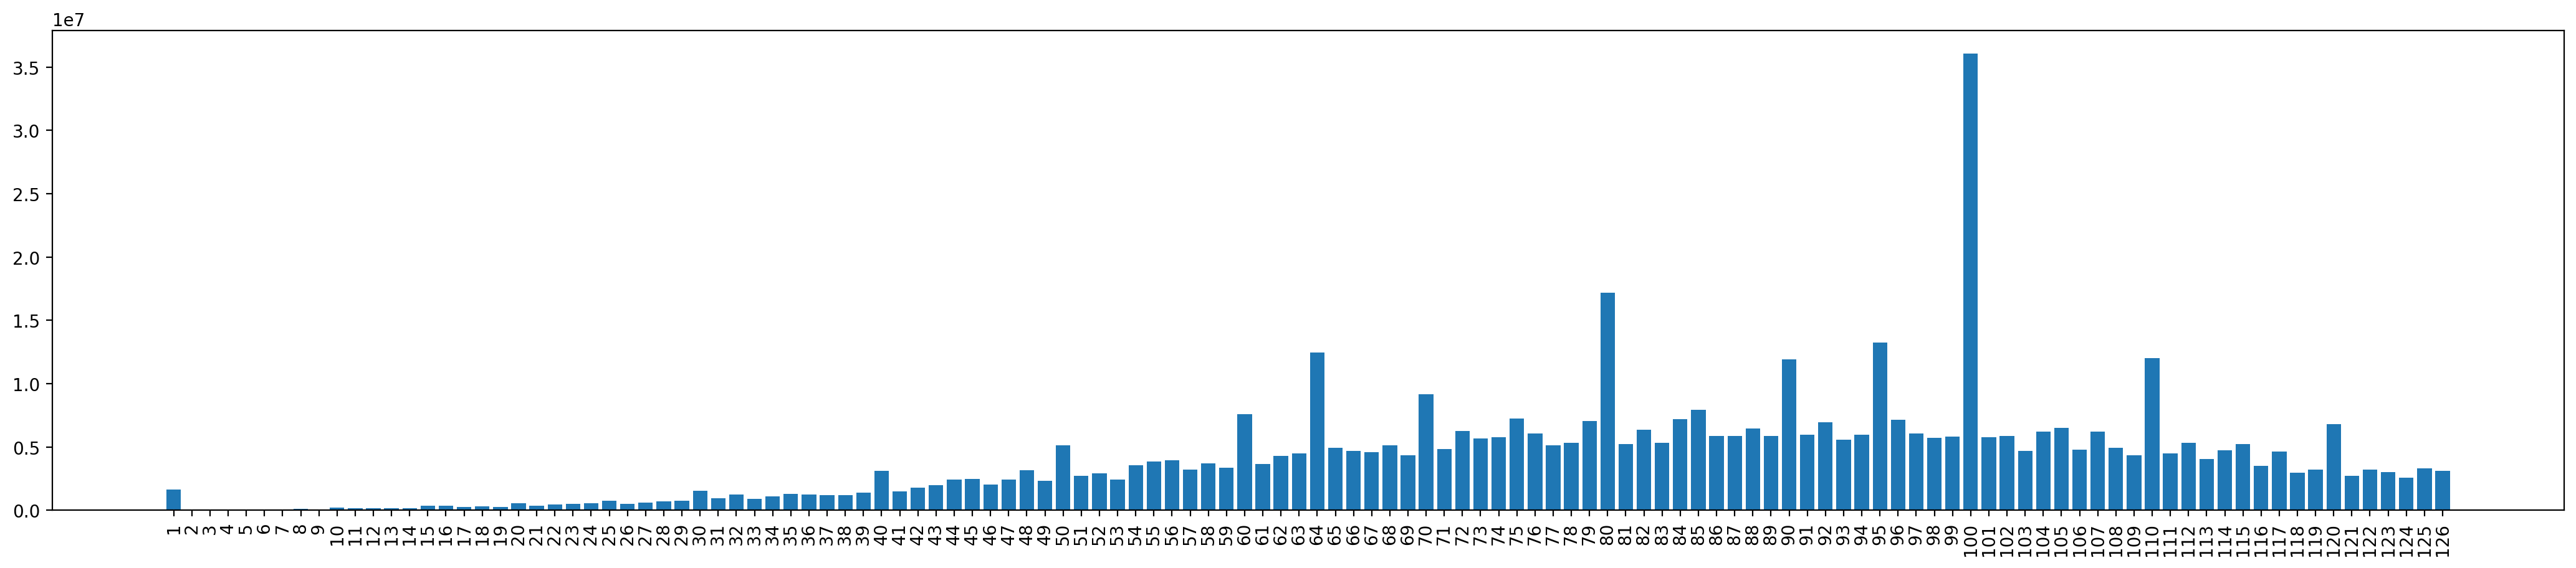

In [15]:
plot_bar_centered(stats["velocity"])

The remaining not shown values amount to 29.39% of the total


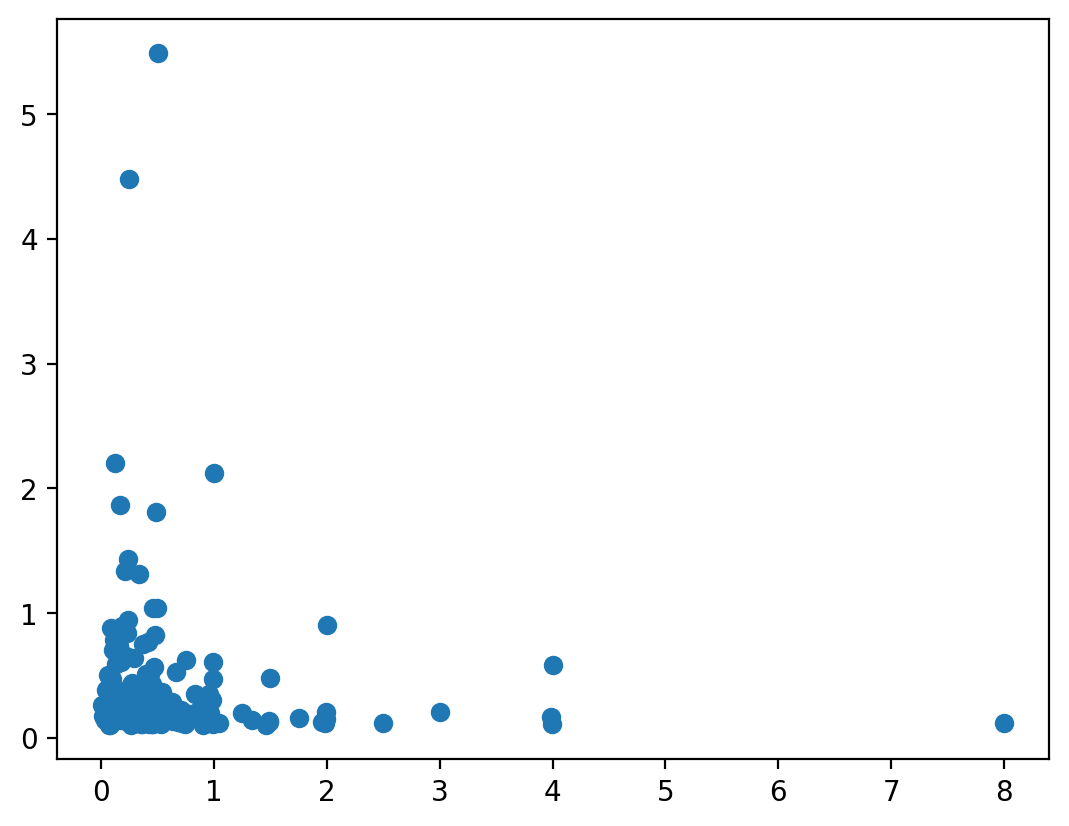

In [16]:
plot_scatter_from_dict(stats["durations"], lim_percentage=1/10)

The remaining not shown values amount to 35.33% of the total


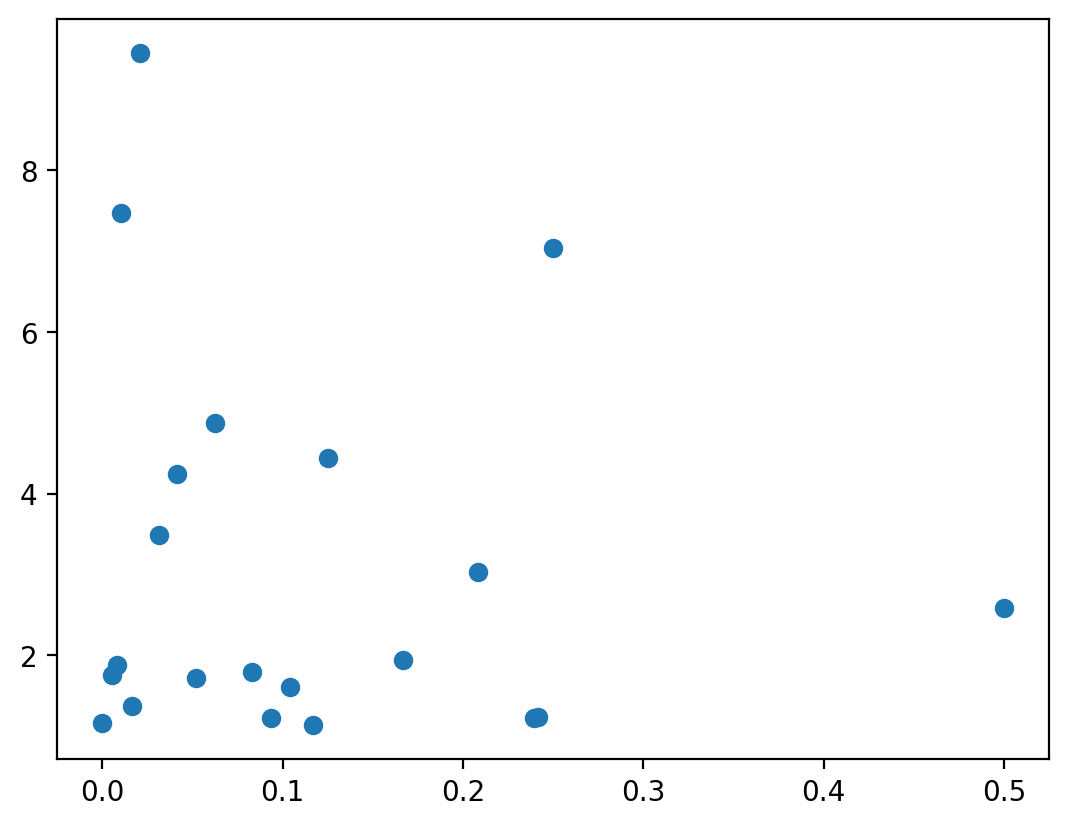

In [17]:
plot_scatter_from_dict(stats["drum_durations"], lim_percentage=1)

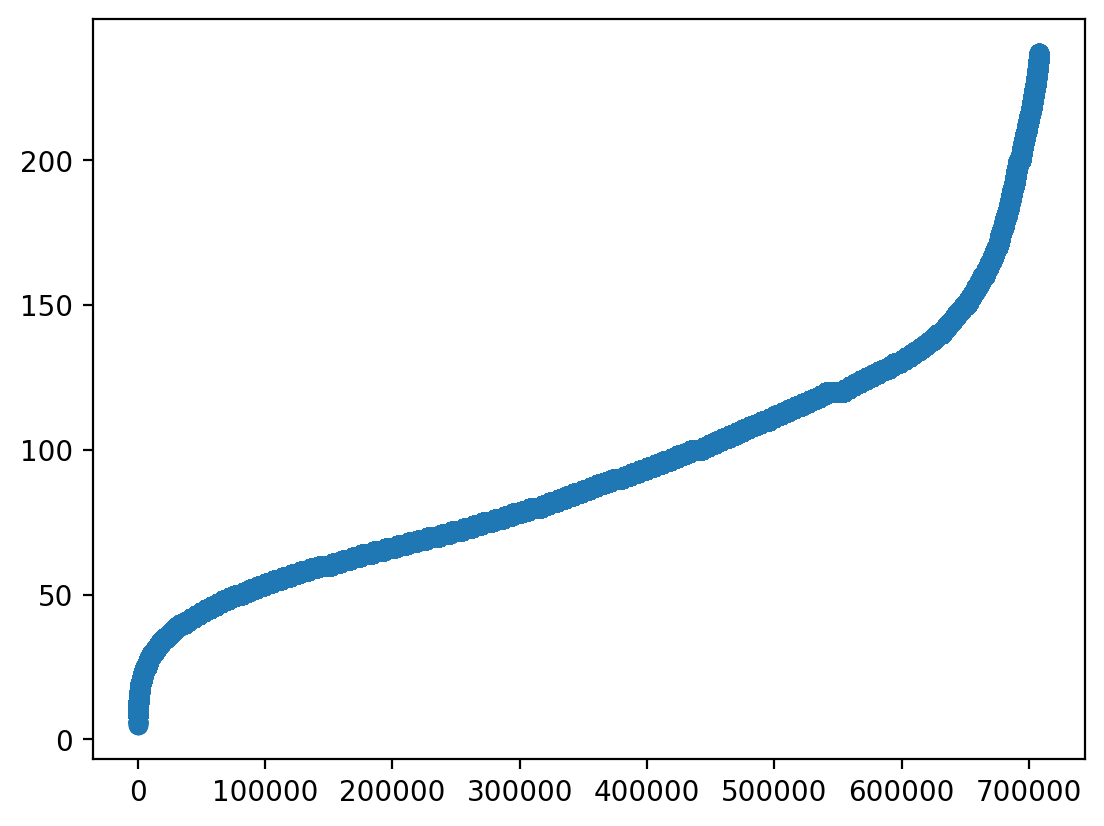

In [18]:
plot_scatter_limit(stats["tempos"], lim=-5000)

The remaining not shown values amount to 0.00% of the total


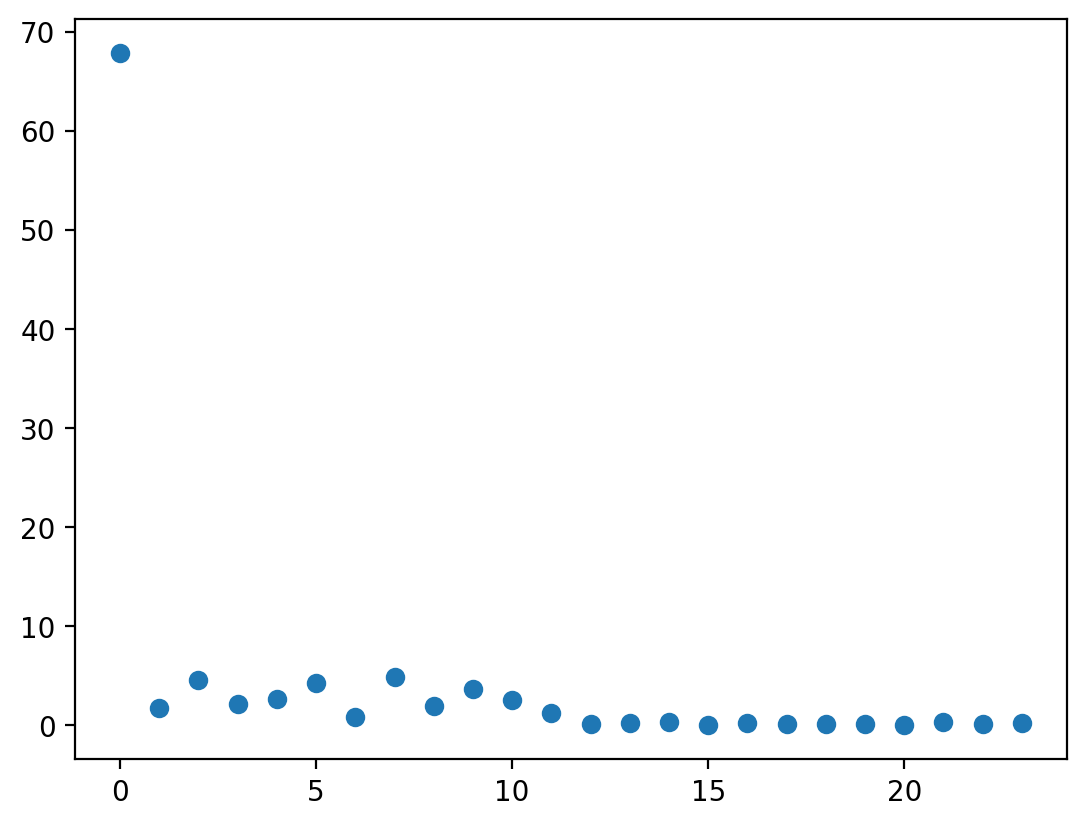

In [21]:
plot_scatter_from_dict(stats["key_signatures"], mapping=utils.key_sign_map)

In [24]:
tot = np.sum(list(stats["time_signatures"].values()))
print(tot)
print()
arr = np.zeros((len(stats["time_signatures"].keys()), 3))

for i, key in enumerate(stats["time_signatures"].keys()):
    arr[i,0] = stats["time_signatures"][key]/tot*100
    arr[i,1] = key[0]
    arr[i,2] = key[1]

arr = arr[arr[:,0].argsort()]

# Numerators
lim_percentage = 0.01
print("The remaining not shown values amount to {:.2f}% of the total".format(sum([x[0] for x in arr if x[0] <= lim_percentage])/sum(arr[:,0])*100))
print(tmp := np.sort(list(set(list([x[1] for x in arr if x[0]>lim_percentage])))))
num_nominators = len(tmp)
print("Total number of accepted numerators {}".format(num_nominators))
print()
# Denominators
lim_percentage = 0
print("The remaining not shown values amount to {:.2f}% of the total".format(sum([x[0] for x in arr if x[0] <= lim_percentage])/sum(arr[:,0])*100))
print(tmp := np.sort(list(set(list([x[2] for x in arr if x[0]>lim_percentage])))))
num_denominators = len(tmp)
print("Total number of accepted denominators {}".format(num_denominators))

print("Total possible time_signatures: {}".format(num_nominators*num_denominators))
# for i in arr:
#     print("{:5.2f}%, {:.0f}/{:.0f}".format(i[0], i[1], i[2]))

124766

The remaining not shown values amount to 0.13% of the total
[  1.   2.   3.   4.   5.   6.   7.   8.   9.  10.  11.  12.  13.  15.
  16.  17.  21. 132.]
Total number of accepted numerators 18

The remaining not shown values amount to 0.00% of the total
[ 2.  4.  8. 16. 32.]
Total number of accepted denominators 5
Total possible time_signatures: 90


In [26]:
def duration_loss(possible_durations: np.array, real_durations: dict, limit_max_len=1e10) -> float:
    loss = 0
    tot_notes = 0
    for dur, num_notes in real_durations.items():
        if dur < limit_max_len:
            new_val = possible_durations[np.argmin(np.abs(possible_durations - dur))]
            loss += np.abs(new_val - dur) * num_notes
            tot_notes += num_notes

    return loss/tot_notes

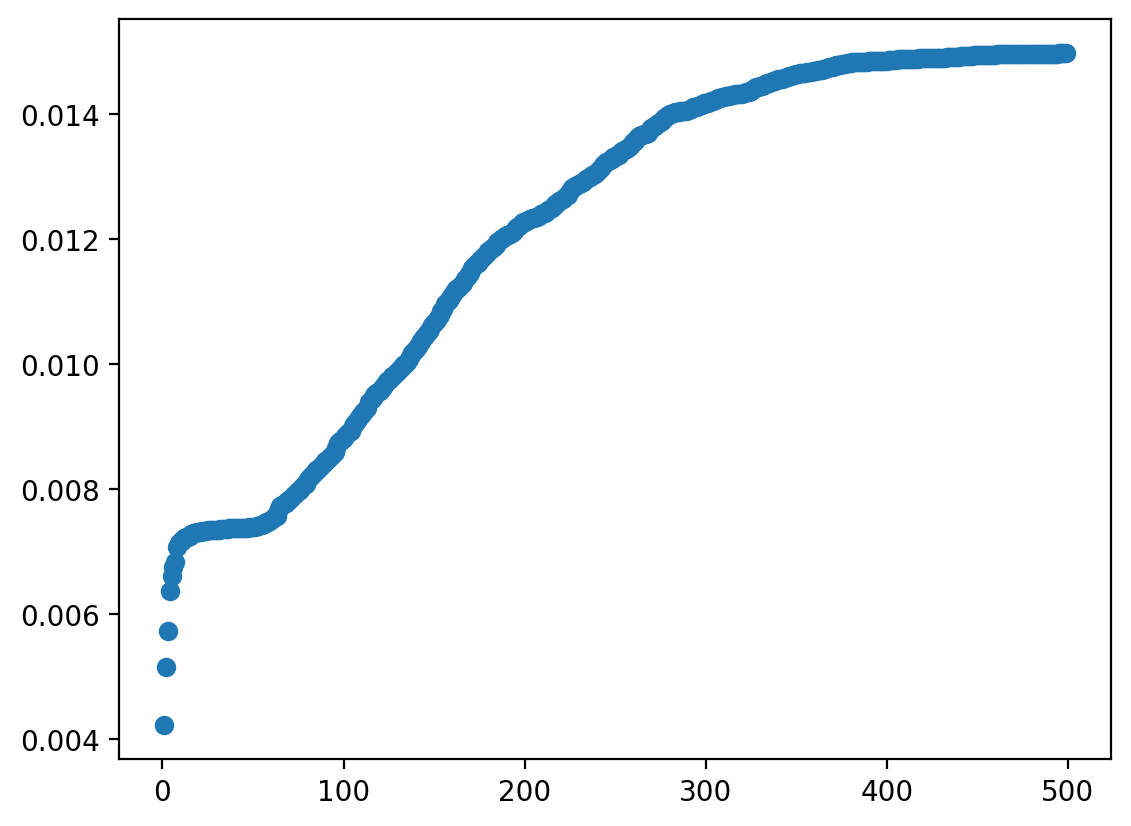

In [28]:
# The mean error with our discretization on "short" (<48 beats) note is 0.67%, if we add long notes it becomes ~2%
plt.scatter(
    range(1,500),
    [duration_loss(conf.np_durations, stats["durations"], limit_max_len=i) for i in np.linspace(1, 500, 50)]
)
plt.xlabel("Maximum length allowed (i.e. snap longer notes to limit_max_len)")

In [29]:
duration_loss(conf.np_durations, stats["durations"], limit_max_len=max(conf.np_durations))

0.007391564897058901

# Song transformation

In [30]:
min = 10000000
idx = -1
for i, song in tqdm(enumerate(dataset)):
    len_song = np.sum([len(track.notes) for track in song.tracks if len(track.notes) > 0])
    if len_song < min and len_song > 0:
        min = len_song
        idx = i

print(min, idx)

4 111536


In [38]:
for track in dataset[idx].tracks:
    print(track.notes)

[]
[Note(time=2385, pitch=48, duration=9103, velocity=119), Note(time=10939, pitch=60, duration=5685, velocity=119), Note(time=15376, pitch=48, duration=4486, velocity=121), Note(time=19788, pitch=55, duration=12751, velocity=114)]


In [32]:
song = utils.transform_representation(dataset[idx], conf)
print("    type  measure     beat position duration    pitch instrume velocity key_sign time_sig    tempo")
for line in song:
    print("{:8.0f} {:8.0f} {:8.0f} {:8.0f} {:8.0f} {:8.0f} {:8.0f} {:8.0f} {:8.0f} {:8.0f} {:8.0f}".format(line[0], line[1], line[2], line[3], line[4], line[5], line[6], line[7], line[8], line[9], line[10]))

    type  measure     beat position duration    pitch instrume velocity key_sign time_sig    tempo
       0        0        0        0        0        0        0        0        0        0        0
       1        0        0        0        0        0       85        0        0        0        0
       2        0        0        0        0        0        0        0        0        0        0
       5        0        0        0        0        0        0        0        0       41        0
       6        0        0        0        0        0        0        0        0        0       35
       3        1        0      127      135       48       85      119        0       41       35
       3        5        2      127      135       60       85      119        0       41       35
       3        8        0      127      135       48       85      121        0       41       35
       3       10        1      127      135       55       85      114        0       41       35
       7  

## Dataset transformation

In [4]:
samples = []
labels = []
discarded_samples = {
    0:0, # empty song
    1:0, # time_signatures not all acceptable
    2:0  # n_measures too big
}

for string in chosen_datasets:
    current_samples = []
    if not os.path.exists(path := os.path.join(ROOT_PATH, "data", string, "numpy")):
        os.mkdir(path)

    for song in (pbar := tqdm(utils.get_dataset(string, conf))):
        pbar.set_description(string)
        # title = song.metadata.title

        # if title == "None":
        #     title = song.metadata.source_filename.split(".")[0]

        converted_song = utils.transform_representation(song, conf)

        if len(converted_song) > 1:
            current_samples.append(converted_song)
            samples.append(converted_song)
            labels.append(utils.map_dataset_to_label(string))
            # np.save(
            #     file = os.path.join(path, title+".npy"),
            #     arr = converted_song.astype(np.uint8)
            # )
        else:
            discarded_samples[converted_song[0]] += 1

            

lmd_matched:   0%|          | 95/115190 [00:09<3:02:04, 10.54it/s]


ValueError: not enough values to unpack (expected 4, got 2)

In [17]:
min(note.time for note in lmd_matched[97].tracks[0].notes)

ValueError: min() arg is an empty sequence

In [ ]:
print("Total accepted songs: {}, {:.2f}% of the initial songs".format(
    len(samples), 
    len(samples)/sum([len(utils.get_dataset(string, conf)) for string in chosen_datasets])*100
))

print("Of the discarded: ")
print("- {:.2f}% were empty".format(discarded_samples[0]/sum(discarded_samples.values())*100))
print("- {:.2f}% contained not accepted time signatures".format(discarded_samples[1]/sum(discarded_samples.values())*100))
print("- {:.2f}% had too many measures".format(discarded_samples[2]/sum(discarded_samples.values())*100))

Total accepted songs: 6924, 91.26% of the initial songs
Of the discarded: 
- 0.90% were empty
- 17.04% contained not accepted time signatures
- 82.05% had too many measures


### Maximum accepted len study
---

In [ ]:
len_x = [len(sample) for sample in samples]
sorted_labels = [y for _, y in sorted(zip(len_x, labels), key=lambda pair: pair[0])]


lengths = {}

for i, (x, y) in enumerate(zip(sorted(len_x), sorted_labels)):
    if y not in lengths.keys():
        lengths[y] = [(i, x)]
    else:
        lengths[y].append((i, x))

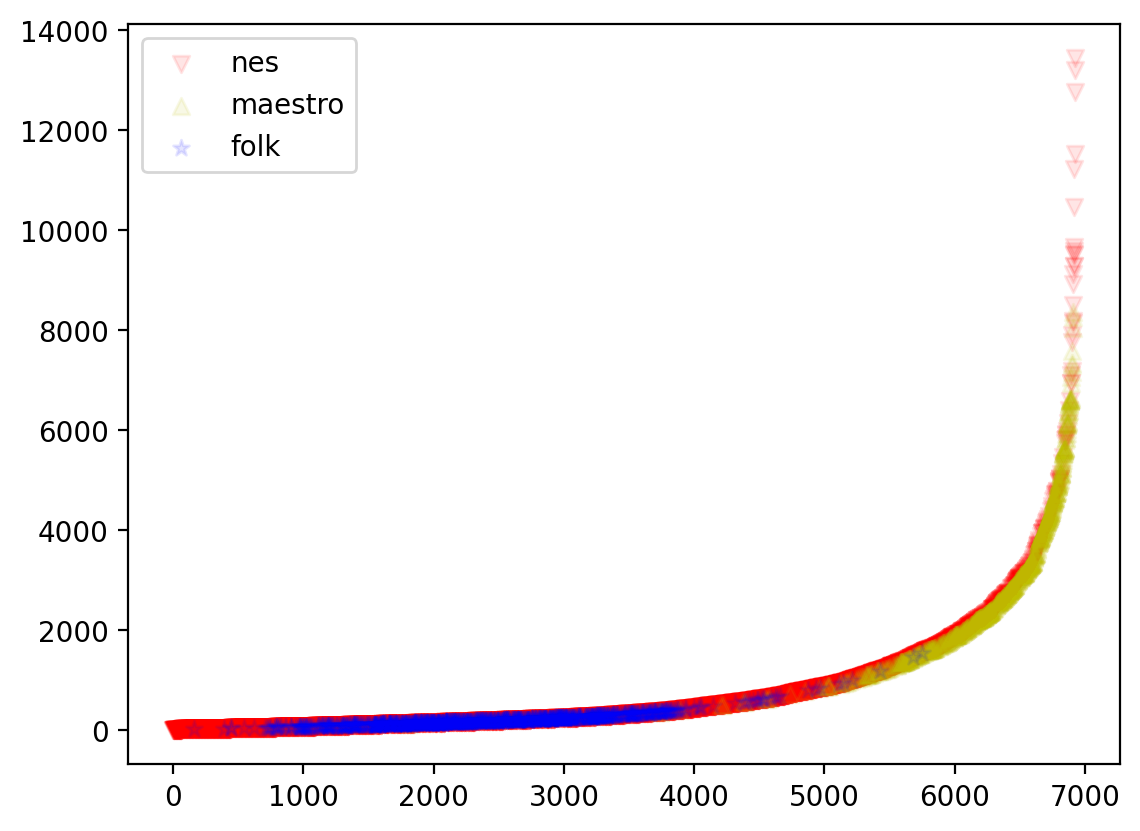

In [ ]:
for dataset_lengths, y in lengths.items():
    plt.scatter([s[0] for s in dataset_lengths], [s[1] for s in dataset_lengths], alpha=0.1)

plt.legend(chosen_datasets);

Text(0.5, 1.0, 'Deleted %')

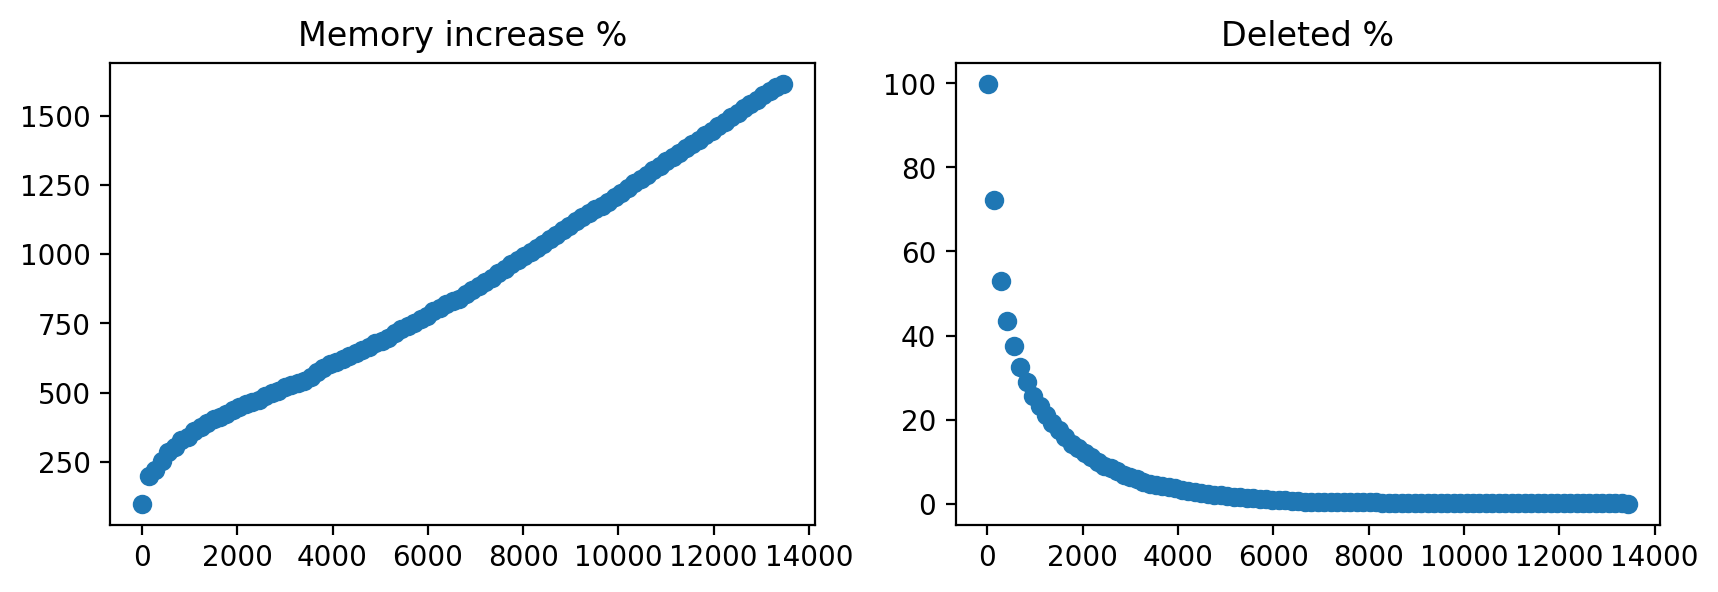

In [ ]:
limits = np.linspace(min(len_x), max(len_x), 100)
deleted = []
memory = []

for i, lim in enumerate(limits):
    deleted.append(sum(1 for l in len_x if l>lim) / len(len_x) * 100)
    memory.append(sum(lim for l in len_x if l<=lim) / sum(l for l in len_x if l<=lim) * 100)

fig, (ax1, ax2) = plt.subplots(1, 2)
fig.set_size_inches(10,3)
ax1.scatter(limits, memory)
ax1.set_title("Memory increase %")
ax2.scatter(limits, deleted)
ax2.set_title("Deleted %")

In [ ]:
chosen_len = 8192
print("With {} as max_limit, we would keep {:.2f}% of songs, {} in total".format(
    chosen_len,
    sum(1 for l in len_x if l<=chosen_len) / len(len_x) * 100,
    sum(1 for l in len_x if l<=chosen_len)
    ))

With 8192 as max_limit, we would keep 99.75% of songs, 6907 in total


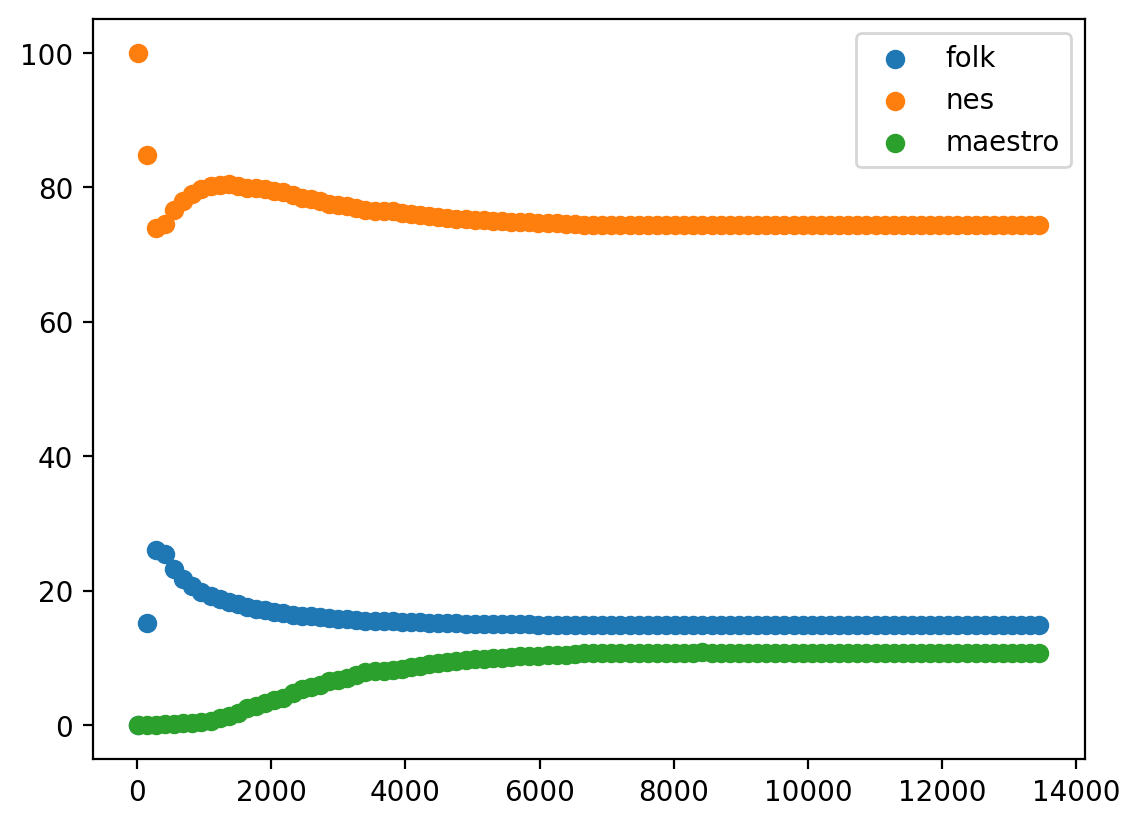

Imbalances at 100% chosen_len: 
folk: 14.80%
nes: 74.44%
maestro: 10.76%
Imbalances at len 8192: 
folk: 14.84%
nes: 74.40%
maestro: 10.76%


In [ ]:
def get_dataset_imbalance(samples, labels, names, chosen_len=None):

    processed_datasets = [[sample for sample, l in zip(samples, labels) if l == label ] for label in np.sort(np.unique(labels))]
    
    if chosen_len == None:

        min_len = np.min([np.min([len(sample) for sample in dataset]) for dataset in processed_datasets])
        max_len = np.max([np.max([len(sample) for sample in dataset]) for dataset in processed_datasets])
        
        lengths = np.linspace(min_len, max_len, 100)

        imbalances = np.zeros((len(lengths), len(processed_datasets)))

        for i, max_len_sample in enumerate(lengths):
            data_quantity = [len([1 for p in dataset if len(p)<=max_len_sample]) for dataset in processed_datasets]
            tot_data = sum(data_quantity)

            imbalances[i, :] = [d/tot_data*100 for d in data_quantity]
        
        for i in range(len(processed_datasets)):
            plt.scatter(lengths, imbalances[:, i])
        plt.legend(names)
        plt.show()

        print("Imbalances at 100% chosen_len: ")
        for name, imb in zip(names, imbalances[-1, :]):
            print("{}: {:.2f}%".format(name, imb))

        return imbalances[-1, :]

    else:
        data_quantity = [len([1 for p in dataset if len(p)<=chosen_len]) for dataset in processed_datasets]
        tot_data = sum(data_quantity)

        imbalances = [d/tot_data*100 for d in data_quantity]

        print("Imbalances at len {}: ".format(chosen_len))
        for name, imb in zip(names, imbalances):
            print("{}: {:.2f}%".format(name, imb))
        
        return imbalances

final_imbalances = get_dataset_imbalance(samples, labels, ["folk", "nes", "maestro"])
imbalances = get_dataset_imbalance(samples, labels, ["folk", "nes", "maestro"], chosen_len=chosen_len)

In [ ]:
# can be reduced for minor memory footprint
chosen_len = max(len(sample) for sample in samples)

In [ ]:
right_shape_samples = []
for sample in tqdm(samples):
        right_shape_samples.append(
            np.concatenate((
                sample,
                np.zeros((chosen_len-len(sample), conf.tuple_size), dtype=np.uint8)
            ), dtype=np.uint8)
        )

dataset = tf.data.Dataset.from_tensor_slices((right_shape_samples, labels))
dataset.save(conf.tf_data_path)

100%|██████████| 7035/7035 [00:00<00:00, 33791.80it/s]


13450
13450


2022-11-11 12:33:12.887529: W tensorflow/core/framework/cpu_allocator_impl.cc:82] Allocation of 8326626000 exceeds 10% of free system memory.
